<a href="https://colab.research.google.com/github/melodyjansen/BayesianStatistics/blob/main/airline_safety_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airline Safety

`A Bayesian data analysis study`

Melody Jansen (s1053601), Ruoqing Fan (s1038659)

## Introduction

In the past there have been some deadly airline crashes causing some people to be hesitant about flying these airlines again. We want to experiment whether this behaviour is rational. Therefore, for this project, we have obtained resources about airline safety of different airlines from the Flight Safety Foundation (FSF). The FSF is an organisation that brings together aviation professionals from all sectors to help solve safety problems facing the industry. It supports sources such as the ASN that provides accurate and authoritative information on airline accidents and safety issues. We will be using the [ASN Accident Database](https://github.com/fivethirtyeight/data/blob/master/airline-safety/airline-safety.csv) that contains detailed descriptions of (fatal) incidents of 57 different airlines in the period of 1985–1999 and 2000–2014. We want to find out whether the number of fatal incidents have decreased in the past years by comparing the rate of fatal incidents in the era's of 1985–1999 and 2000–2014. Our research question is thus: “Did the rate of fatal aviation incidents decrease between the available measured periods, 1985–1999 and 2000–2014?” as we take in consideration that some airplanes are capable of handling crashes (and thus not end up fatal).

Most people that are scared of flying the airlines that have had fatal incidents in the past assume that the rate will not decrease (airlines do not get better at handling incidents). To test whether this is really the case we will perform Bayesian model comparison.

We define two models: $m_1$, in which there is a difference between the periods, and $m_0$ in which there is no difference. In both models, we will be analysing by estimating the prior and posterior number of fatal aviation incidents differences, and using the approach with the categorical model variable $m$ in JAGS to compute the Bayes factor. There are many ways to implement this model comparison, but we choose the categorical approach because we have observations that fall into discrete groups (Different, Not different) and are already familiar with this approach. After that, we will try another approach, namely the Savage-Dickey approach, to double-check our results and confirm our answer to the research question. We can use this approach by formulating our null model with a precise hypothesis (e.g. difference is exactly 0), which greatly simplifies our computations of the Bayes factor.

In [ ]:
!apt install jags
!pip install pyjags
!pip install daft

Reading package lists... Done
Building dependency tree       
Reading state information... Done
jags is already the newest version (4.3.2-1.2004.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
from scipy.special import betaln
import numpy as np
import pyjags as pj
import csv
import daft

print('Using PyJAGS v{:s}'.format(pj.__version__))

plt.rc('axes', titlesize=18)        # fontsize of the axes title
plt.rc('axes', labelsize=18)        # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)       # fontsize of the tick labels
plt.rc('ytick', labelsize=14)       # fontsize of the tick labels
plt.rc('legend', fontsize=12)       # legend fontsize
plt.rc('figure', titlesize=30)      # fontsize of the figure title

Using PyJAGS v1.3.8


In [ ]:
with open('airline-safety.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    airlines = []
    incidents_85_99 = []
    incidents_00_14 = []
    fatal_inc_85_99 = []
    fatal_inc_00_14 = []
    for row in readCSV:
        airline = row[0]
        incident_85_99 = row[2]
        incident_00_14 = row[5]
        fatal_incident_85_99 = row[3]
        fatal_incident_00_14 = row[6]

        airlines.append(airline)
        incidents_85_99.append(incident_85_99)
        incidents_00_14.append(incident_00_14)
        fatal_inc_85_99.append(fatal_incident_85_99)
        fatal_inc_00_14.append(fatal_incident_00_14)

    airlines = airlines[1:]
    incidents_85_99 = incidents_85_99[1:]
    incidents_00_14 = incidents_00_14[1:]
    fatal_inc_85_99 = fatal_inc_85_99[1:]
    fatal_inc_00_14 = fatal_inc_00_14[1:]

In [ ]:
# Convert incident counts from strings to integers
incidents_85_99 = [int(incident) for incident in incidents_85_99]
incidents_00_14 = [int(incident) for incident in incidents_00_14]
fatal_inc_85_99 = [int(incident) for incident in fatal_inc_85_99]
fatal_inc_00_14 = [int(incident) for incident in fatal_inc_00_14]

# Compute the number of incidents from the database
print("Total number of incidents in 1985-1999:", sum(incidents_85_99))
print("Total number of incidents in 2000-2014:", sum(incidents_00_14))
print("Number of fatal incidents in 1985-1999:", sum(fatal_inc_85_99))
print("Number of fatal incidents in 2000-2014:", sum(fatal_inc_00_14))

Total number of incidents in 1985-1999: 402
Total number of incidents in 2000-2014: 231
Number of fatal incidents in 1985-1999: 122
Number of fatal incidents in 2000-2014: 37


## Model comparison

First, to get the total number of incidents in 1985-1999 $(P1)$ and 2000-2014 $(P2)$, we made the computations above.
As it can be seen, the results from the ASN Accident Database are that out of $N_{P1} = 402$ incidents, $z_{P1} = 122$ are fatal and out of $N_{P2}=231$ incidents, $z_{P2} = 37$ are fatal.

For our Bayesian model comparison, we define the null model $m_0$: $\theta_{P1} = \theta_{P2}$, and the alternative model, $m_0$: $\theta_{P1} \neq \theta_{P2}$. We will be using the approach with the categorical model variable $m$ in JAGS.

### Generative models

For the null model, $m_0$, where the success (incident is fatal) probabilites for the periods 1985-1999 $(P1)$ and 2000-2014 $(P2)$ appears to be the same, we can describe the prior as a spike distribution with $c=0.5$ and the likehood as a Binomial distribution. We set the variable $c$ to 0.5 as the null model suggests that there is an equal outcome. We choose the Binomial distribution as our likelihood as the Binomial distribution is appropriate when we have a fixed number of independent Bernoulli trials (in this case, whether an incident is fatal or not) and we want to model the number of successes (fatal incidents) out of those trials. The parameters of the Binomial distribution are the number of trials ($N_{P1}$ or $N_{P2}$) and the success probability ($\theta_{P1}$ or $\theta_{P2}$).

This gives the generative model $\enspace m_0:=$

\begin{equation}
\begin{split}
\theta_{P1} \mid c &\sim \text{spike}(\theta_{P1} \mid c) \\
\theta_{P2} \mid c &\sim \text{spike}(\theta_{P2} \mid c) \\
z_{P1} \mid N_{P1}, \theta_{P1} &\sim \text{Binomial}(N_{P1}, \theta_{P1}) \\
z_{P2} \mid N_{P2}, \theta_{P2} &\sim \text{Binomial}(N_{P2}, \theta_{P2}) \\
\end{split}
\end{equation}
$\enspace$

The alternative model, $m_1$, where the success probabilities for the first period $P1$ (1985-1999) and the second period $P2$ (2000-2014) are different, treats $\theta$ as a latent parameter, and
assigns it a ‘real’ prior, the beta distribution. We use the beta distribution, because it is a conjugate prior for the binomial likelihood. Accordingly for the likehood, the Binomial distribution is used, for the same reasons as explained earlier.

So we have the generative model $\enspace m_1:=$

\begin{equation}
\begin{split}
\theta_{P1} \mid a, b &\sim \text{beta}(a, b) \\
\theta_{P2} \mid a, b &\sim \text{beta}(a, b) \\
z_{P1} \mid N_{P1}, \theta_{P1} &\sim \text{Binomial}(N_{P1}, \theta_{P1}) \\
z_{P2} \mid N_{P2}, \theta_{P2} &\sim \text{Binomial}(N_{P2}, \theta_{P2}) \\
\end{split}
\end{equation}

### Graphical models

Below, we have their respective graphical representation.

/usr/local/lib/python3.10/dist-packages/daft.py:842: RuntimeWarning: divide by zero encountered in double_scalars
  * np.abs(dy / dx)


<Axes: >

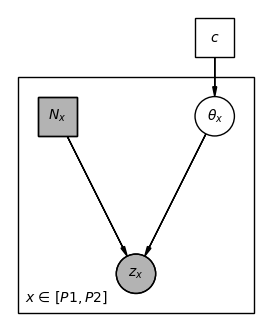

In [ ]:
# Graphical representation for m0

pgm = daft.PGM()

# Nodes (rectangle shape represents diamond shape)
pgm.add_node(daft.Node("c", r"$c$", x=2, y=3, shape="rectangle"))
pgm.add_node(daft.Node("N", r"$N_x$", x=0, y=2, shape="rectangle", observed=True))
pgm.add_node(daft.Node("theta", r"$\theta_x$", x=2, y=2, shape="ellipse"))
pgm.add_node(daft.Node("z", r"$z_x$", x=1, y=0, shape="ellipse", observed=True))

# Edges
pgm.add_edge("c", "theta")
pgm.add_edge("N", "z")
pgm.add_edge("theta", "z")

# Plate
pgm.add_plate(daft.Plate([-0.5,-0.5, 3, 3], label="$x$ $∈$ $[P1, P2]$"))

# Render
pgm.render()

<Axes: >

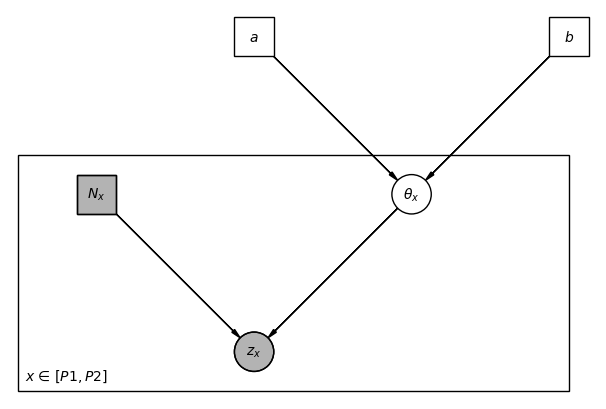

In [ ]:
# Graphical representation for m1

pgm = daft.PGM()

# Nodes (rectangle shape represents diamond shape)
pgm.add_node(daft.Node("a", r"$a$", x=4, y=4, shape="rectangle"))
pgm.add_node(daft.Node("b", r"$b$", x=8, y=4, shape="rectangle"))
pgm.add_node(daft.Node("N", r"$N_x$", x=2, y=2, shape="rectangle", observed=True))
pgm.add_node(daft.Node("theta", r"$\theta_x$", x=6, y=2, shape="ellipse"))
pgm.add_node(daft.Node("z", r"$z_x$", x=4, y=0, shape="ellipse", observed=True))

# Edges
pgm.add_edge("a", "theta")
pgm.add_edge("b", "theta")
pgm.add_edge("theta", "z")
pgm.add_edge("N", "z")

# Plate
pgm.add_plate(daft.Plate([1, -0.5, 7, 3], label="$x$ $∈$ $[P1, P2]$"))

# Render
pgm.render()


### JAGS implementation

Next, we want to implement the model comparison in JAGS. For this, we make use of the fact that in $m_0$, $\theta_{P1}$ and $\theta_{P2}$ are the same. That means we can sample one, and then _set_ the other.

In [ ]:
jags_model = '''
model {
    ## Prior
    m ~ dcat(model_probs)
    theta_P1 ~ dbeta(a, b)
    theta_P2 ~ dbeta(a, b)

    theta_P2_2 = ifelse(m==1, theta_P1, theta_P2)

    ## Likelihood
    z_P1 ~ dbin(theta_P1, N_P1)
    z_P2 ~ dbin(theta_P2_2, N_P2)
}
'''

N_P1 = 402
z_P1 = 122

N_P2 = 231
z_P2 = 37

# using a relatively non-informative prior
a = 1
b = 1

# assigning prior probabilities
model_probs = [0.5, 0.5]

data = dict(N_P1=N_P1, N_P2=N_P2, z_P2=z_P2, z_P1=z_P1, a=a, b=b, model_probs=model_probs)

num_samples = 400000
num_chains = 4
m = pj.Model(jags_model, data=data, chains=num_chains)

samples = m.sample(num_samples, vars=['m','theta_P1', 'theta_P2_2', 'z_P2', 'z_P1'])
print('Sampling complete.')

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 1600000 of 1600000, elapsed 0:00:05, remaining 0:00:00
sampling: iterations 1600000 of 1600000, elapsed 0:00:05, remaining 0:00:00
Sampling complete.


### Bayes factor

The Bayes factor is the ratio of evidence for the two models, which is computed as:
$$
    BF_{10} = \frac{p(D \mid m_1)}{p(D \mid m_0)} = \frac{p(z \mid N, m_1)}{p(z \mid N, m_0)} \enspace
$$

For our model comparison, we compute the posterior model probabilities and the Bayes factor as follows:

In [ ]:
# Posterior model probability
m_samples = samples['m'].flatten()
pmp1 = np.mean(m_samples) - 1 # our categorical
pmp0 = 1 - pmp1
print("Posterior probability of m0: {}".format(pmp0))
print("Posterior probability of m1: {}".format(pmp1))

# JAGS Bayes factor
BF_10 = pmp1/pmp0
print("JAGS Bayes factor: {}".format(BF_10))

Posterior probability of m0: 0.002847499999999892
Posterior probability of m1: 0.9971525000000001
JAGS Bayes factor: 350.18525021950416


According to the Bayes factor interpretation table, we have obtained decisive evidence, meaning it supports model  $m_1$. We can conclude from this that there is definitely a difference between $z_{P1}$ and $z_{P2}$, meaning that fatality rate of an incident during $P1$ (1985-1999) differs from the fatality rate of an incident during $P2$ (2000-2014).

## Savage-Dickey approach

We would like to see if our findings can be confirmed by other model comparison approaches. Here, we will utilize the Savage-Dickey approach.

In order to do so, we will first start by reformulating the earlier used alternative model, denoted as $m_1$, to explicitly capture the difference in the incident rate between $P1$ (1985-1999) and $P2$ (2000-2014) as $\delta=\theta_{P1}-\theta_{P2}$. In the null model $m_0$, this means that $\delta = 0$.

The Savage-Dickey approach can be used to compare two models when one model is a special case of the other model. In this case, the null model is $\theta_{P1} - \theta_{P2} = 0$ and the alternative model is $\theta_{P1} - \theta_{P2} \neq 0$. The alternative model $m_1$ can be observed as the complement of the null model $m_0$.


Using the Savage-Dickey approach, we compute the Bayes factor as follows:

$$
    BF_{10} = \frac{p(D \mid m_1)}{p(D \mid m_0)} = \frac{p(\delta=\delta_0 \mid m_1)}{p(\delta=\delta_0 \mid D, m_1)} \enspace,
$$

Here, $\delta_0$ is the value specified by the null model.

For this, we do not have to specify a prior on $\delta$ explicitly. We can simply include $\delta=\theta_{P1}-\theta_{P2}$ in our generative model and JAGS implementation: when no observations are provided to the model, we simply sample from the prior distribution. This enables us to obtain samples from $\delta \sim p(\delta=\delta_0 \mid m_1)$. Conversely, if we do include data to condition the model, we obtain samples from $\delta \sim p(\delta=\delta_0 \mid D, m_1)$.

### JAGS implementation

We start off by implementing the model $m_1$ in JAGS with the explicit sampling of  $\delta = \theta_{P1} - \theta_{P2}$. Samples will be collected from the prior and the posterior.

In [ ]:
jags_model = '''
model {
    ## Prior
    theta_P1 ~ dbeta(a, b)
    theta_P2 ~ dbeta(a, b)

    theta_P1.prior ~ dbeta(a, b)
    theta_P2.prior ~ dbeta(a, b)

    delta = theta_P1 - theta_P2
    delta.prior = theta_P1.prior - theta_P2.prior

    ## Likelihood
    z_P1 ~ dbin(theta_P1, N_P1)
    z_P2 ~ dbin(theta_P2, N_P2)
}
'''

data = dict(N_P1=N_P1, N_P2=N_P2, z_P2=z_P2, z_P1=z_P1, a=a, b=b)

m = pj.Model(jags_model, data=data, chains=num_chains)

samples = m.sample(num_samples, vars=['delta', 'delta.prior'])
print('Sampling complete.')

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 1600000 of 1600000, elapsed 0:00:04, remaining 0:00:00
Sampling complete.


### Plots

We will visualize both the histogram of the prior and posterior, sampled from the JAGS model, within one figure.

Text(0.5, 1.0, 'Posterior samples')

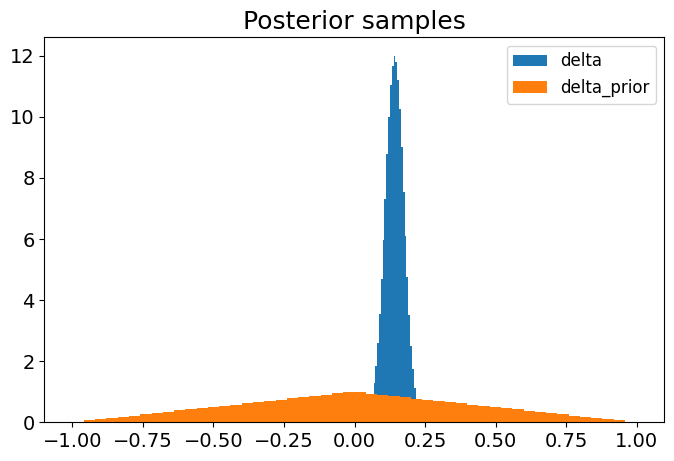

In [ ]:
plt.figure(figsize=(8, 5))
ax = plt.gca()
delta_samples = samples['delta'].flatten()
delta_prior_samples = samples['delta.prior'].flatten()

ax.hist(delta_samples, density=True, bins=50, label='delta')
ax.hist(delta_prior_samples, density=True, bins=50, label='delta_prior')
ax.legend()
ax.set_title('Posterior samples')

The prior distribution represents the belief about the variable $\delta$, the difference in fatality rate of an incident between the period $P1$ (1985-1999) and $P2$ (2000-2014), which is 0 according to the null model, before observing any data. The posterior distribution represents the updated belief about $\delta$ after observing the data. By comparing the prior and posterior histograms, it can be seen in the plot above how the data has influenced the distribution. The posterior is much narrower and more concentrated around certain values compared to the prior, suggesting that the data has provided more information, and the uncertainty has reduced. Moreover, it can be seen that according to the posterior distribution, the variable $\delta$ is most likely not 0, as the peak of the distribution occurs between the values 0.05 and 0.25.

In order to compute the Savage-Dickey density ratio, we need to obtain the probabilities indicated at the value $\delta=0$ in these histograms. However, reading that with the naked eye from histograms is not particularly accurate. Instead, we will use _kernel density estimation_. This technique smooths the histogram, but also allows us to query the probability density function that the histogram approximates, at any location of our choice. The function we use is `scipy.stats.gaussian_kde`.

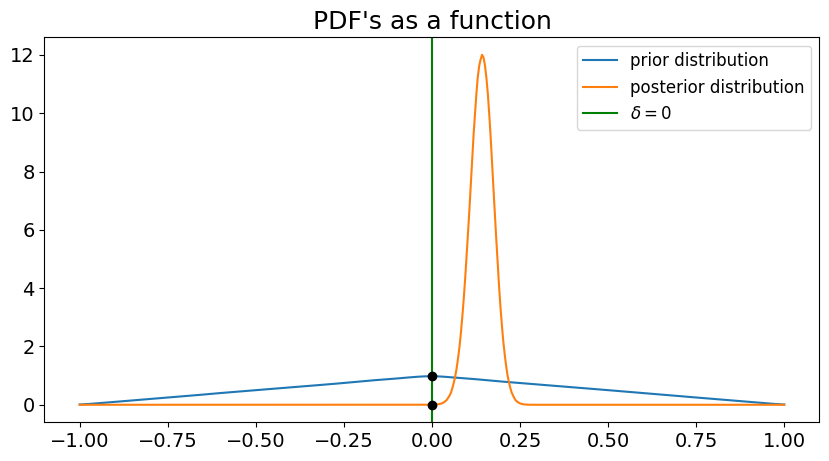

In [ ]:
from scipy.stats import gaussian_kde

posterior = gaussian_kde(delta_samples)
prior = gaussian_kde(delta_prior_samples)

# the resolution of the linspace determines how smooth the plots are
delta_min, delta_max = -1.0, 1.0
delta_range = np.linspace(delta_min, delta_max, num=500)
delta_according_to_m0 = 0

plt.figure(figsize=(10, 5))
ax = plt.gca()

# plot PDF's of posterior and prior distributions
ax.plot(delta_range, prior(delta_range), label='prior distribution')
ax.plot(delta_range, posterior(delta_range), label='posterior distribution')

# add vertical line
ax.axvline(delta_according_to_m0, color='green', label=r'$\delta = 0$')

# add black dots
ax.plot(delta_according_to_m0, prior(delta_according_to_m0), marker='o', color='k')
ax.plot(delta_according_to_m0, posterior(delta_according_to_m0), marker='o', color='k')

# add labels and title
ax.legend(fontsize=12)
ax.set_title("PDF's as a function");

In the plot above, we have determined the PDFs of the posterior and the prior distributions $p(\delta \mid m_1)$ by applying the `gaussian_kde` function on the samples from our JAGS model. These PDFs are plotted as a function from the possible range of $\delta$ ($\delta \in [-1, 1]$). Black dots are added at the points where the prior and the posterior intersect the vertical line of $\delta=0$, as implied by the null model $m_0$. These are the values we will use for our Bayes factor computations using the Savage-Dickey approach.

### Bayes factor

With the prior and posterior probabilities indicated at $\delta=0$, obtained from the smoothened histograms, we can compute the Bayes factor of this model comparison as follows:

In [ ]:
# Bayes factor using the Savage-Dickey approach
new_BF_10 = prior(delta_according_to_m0)/posterior(delta_according_to_m0)
print("Savage-Dickey Bayes factor: {}".format(new_BF_10[0]))

# Comparing the different Bayes factors
print("JAGS Bayes factor was: {}".format(BF_10))
percent_difference = (abs(BF_10 - new_BF_10[0]) / abs(BF_10)) * 100
print("The percent difference is: {}".format(percent_difference))


Savage-Dickey Bayes factor: 320.0316413132921
JAGS Bayes factor was: 350.18525021950416
The percent difference is: 8.610759273073636


From the computations, the percent difference was at first approximately 60, meaning that the Bayes factor we computed using the Savage-Dickey approach was not close to the value we found with the previous model comparison in JAGS. However, since both approaches are based on MCMC sampling (results are not exact) and our results were still roughly within the same ballpark, we could simply increase the number of JAGS samples. By setting the JAGS samples to 400000 (initially 100000), we were able to find the value of the Savage-Dickey Bayes factor that was close to the JAGS Bayes factor (they are within 10% of each other).

## Conclusion


We have defined two models: $m_1$, which has a difference between the periods, and $m_0$, which does not. We evaluated the prior and posterior number of fatal aviation incident differences for both models, and we computed the Bayes factor in JAGS using the approach with the categorical model variable $m$. We picked the categorical approach for this since we had observations that fit into discrete groups (Different, Not different) and because we were already acquainted with this approach. After this, we attempted another method, the Savage-Dickey method, to see if our results matched. This strategy was applied by structuring our null model with a precise hypothesis (difference is exactly 0), which substantially simplified our Bayes factor computations.

Both the JAGS Bayes factor with the categorical model variable $m$ and the Savage-Dickey Bayes factor reported to us that the evidence strongly supports the alternative model ($m_1$) over the null model ($m_0$). This indicates that the incident fatality rates differ between $P1$ (1985-1999) and $P2$ (2000-2014). Specifically, the incident fatality rates has decreased between the measured periods, as indicated by the peak of the posterior distribution around the positive values of $\delta$ (which was $\theta_{P1} - \theta_{P2}$) in the graphs. Any reported variations are thus unlikely to have occurred by coincidence, implying that there has been a shift in the way airlines handle incident situations. It implies that changes in aviation procedures, legislation, technology, or other variables may have led to the improvement or deterioration of airline safety. Understanding these characteristics can assist aviation authorities, airlines, and policymakers in making educated decisions to improve safety procedures and reduce risks.

## Source

The data set that we selected from the publicly available repository from the statistical analysis company FiveThirtyEight:

https://github.com/fivethirtyeight/data/tree/master/airline-safety